In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

/Users/kunthshah/Desktop/Crypto-Price-Moevement-Prediction/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
df = pd.read_csv('Dataset/crypto_monthly.csv') 
df.head()

,Date,Open_Price,Close_Price,High_Price,Low_Price,Volume,RSI,Volatility,Global_Economy,Sentiment_Score,Event_Impact,MA_5,MA_10,Price_Change,Price_Movement
0,2023-10-31,57397.216577,48824.312969,57411.578393,30541.786398,164421430,49.637677,0.029853,0.580645,0.063855,0.050326,50612.089545,47991.859734,-8572.903608,0
1,2023-11-30,51782.740012,33747.230312,60069.188441,29977.796001,185657473,45.759111,0.039044,0.533333,0.182264,0.045588,49290.616691,46529.061480,-18035.509700,0
2,2023-12-31,31380.079261,58245.585090,58945.959817,30249.517162,171450601,48.522087,0.048923,0.483871,0.064615,0.039810,50870.775888,49225.015011,26865.505829,1
3,2024-01-31,41583.079134,57745.278803,60388.438312,30052.887555,174184771,48.930698,0.013260,0.483871,0.061566,0.051840,50911.340042,50546.430321,16162.199669,1
4,2024-02-29,55752.382555,31995.906859,59206.502071,29863.830293,157162993,49.878218,0.024224,0.724138,0.196273,0.049517,46111.662807,49156.465648,-23756.475696,0


In [3]:
df.dtypes

Date                object
Open_Price         float64
Close_Price        float64
High_Price         float64
Low_Price          float64
Volume               int64
RSI                float64
Volatility         float64
Global_Economy     float64
Sentiment_Score    float64
Event_Impact       float64
MA_5               float64
MA_10              float64
Price_Change       float64
Price_Movement       int64
dtype: object

In [4]:
#Convert date to type datetime
df['Date'] = pd.to_datetime(df['Date'])

#drop Price_Change and Close_Price
df.drop(['Price_Change', 'Close_Price'], axis=1, inplace=True)

#drop null
df.dropna(inplace=True)

print(df.dtypes)

Date               datetime64[ns]
Open_Price                float64
High_Price                float64
Low_Price                 float64
Volume                      int64
RSI                       float64
Volatility                float64
Global_Economy            float64
Sentiment_Score           float64
Event_Impact              float64
MA_5                      float64
MA_10                     float64
Price_Movement              int64
dtype: object


In [5]:
# Exclude non-feature columns from scaling
cols_to_scale = df.columns.difference(['Date', 'Price_Movement'])

# Scale the features
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df[cols_to_scale])

# Create dataframe with scaled features
features_scaled_df = pd.DataFrame(scaled_values, columns=cols_to_scale, index=df.index)

# Add the target column back without scaling
features_scaled_df['Price_Movement'] = df['Price_Movement']
features_scaled_df['Date'] = df['Date']

print(features_scaled_df.head())

   Event_Impact  Global_Economy  High_Price  Low_Price     MA_10      MA_5  \
0      0.050603        0.857464   -2.259642   0.164044  1.229011  1.557150   
1     -0.848521        0.343342    0.463375  -0.409923  0.674182  1.206650   
2     -1.945250       -0.194149   -0.687497  -0.133395  1.696738  1.625763   
3      0.338001       -0.194149    0.790482  -0.333503  2.197941  1.636522   
4     -0.102843        2.416752   -0.420543  -0.525905  1.670738  0.363483   

   Open_Price       RSI  Sentiment_Score  Volatility    Volume  \
0    1.418835 -0.192801         0.608173   -0.018779 -0.197715   
1    0.779749 -2.041172         1.720789    0.786756  1.271124   
2   -1.542648 -0.724447         0.615317    1.652625  0.288473   
3   -0.381260 -0.529719         0.586669   -1.473129  0.477588   
4    1.231606 -0.078169         1.852418   -0.512173 -0.699761   

   Price_Movement       Date  
0               0 2023-10-31  
1               0 2023-11-30  
2               1 2023-12-31  
3         

In [6]:
# Define the window size
window_size = 60

def create_time_windows(data, window_size):
    X_windows = []
    y_windows = []
    
    # Loop starting from window_size to the end of data rows
    for i in range(window_size, len(data)):
        # Get window of features for the previous window_size days
        X_window = data.iloc[i-window_size:i].values
        # Get the target for the current day (could be adjusted as needed)
        y_window = features_scaled_df.iloc[i]['Price_Movement']
        X_windows.append(X_window)
        y_windows.append(y_window)
    
    return np.array(X_windows), np.array(y_windows)

# Prepare features (drop Date and Price_Movement columns)
features = features_scaled_df.drop(['Date', 'Price_Movement'], axis=1)

# Create the windows
X_seq, y_seq = create_time_windows(features, window_size)

# Check the shapes. X_seq should have shape (samples, 30, num_features)
print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)

X_seq shape: (1574, 60, 11)
y_seq shape: (1574,)


In [7]:
def create_train_val_test_split(X, y, train_ratio=0.7, val_ratio=0.15):

    n = len(X)
    
    # Calculate the split indices
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)
    
    # Split the data
    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Create the splits with default 70-15-15 ratio
X_train, y_train, X_val, y_val, X_test, y_test = create_train_val_test_split(X_seq, y_seq)

# Print the shapes to verify
print(f"Training set: X shape = {X_train.shape}, y shape = {y_train.shape}")
print(f"Validation set: X shape = {X_val.shape}, y shape = {y_val.shape}")
print(f"Test set: X shape = {X_test.shape}, y shape = {y_test.shape}")

Training set: X shape = (1101, 60, 11), y shape = (1101,)
Validation set: X shape = (236, 60, 11), y shape = (236,)
Test set: X shape = (237, 60, 11), y shape = (237,)


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

# Combine train and validation data for cross-validation
# Assuming X_train, y_train, X_val, y_val are already defined
X_combined = np.concatenate([X_train, X_val], axis=0)
y_combined = np.concatenate([y_train, y_val], axis=0)

# Get shapes for model creation
_, timesteps, n_features = X_combined.shape

# Define the model creation function (unchanged)
def create_lstm_model(timesteps, n_features):
    model = Sequential()
    # Add CNN layers with same padding to preserve sequence length
    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(timesteps, n_features)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
    # Add deeper LSTM layers
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(64, return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Dense layers
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Set up K-fold cross-validation
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Lists to store metrics
fold_train_losses = []
fold_val_losses = []
fold_train_accs = []
fold_val_accs = []
all_conf_matrices = []
histories = []

# Perform cross-validation
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_combined)):
    print(f"\nFold {fold+1}/{n_folds}")
    
    # Split data for this fold
    X_train_fold, X_val_fold = X_combined[train_idx], X_combined[val_idx]
    y_train_fold, y_val_fold = y_combined[train_idx], y_combined[val_idx]
    
    # Create a fresh model for each fold
    model = create_lstm_model(timesteps, n_features)
    
    # Set up callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint(f'best_lstm_model_fold_{fold+1}.h5', save_best_only=True, monitor='val_loss')
    ]
    
    # Train the model
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=10,
        batch_size=64,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=callbacks,
        verbose=1
    )
    
    # Store training history
    histories.append(history)
    
    # Evaluate on training and validation data
    train_loss, train_acc = model.evaluate(X_train_fold, y_train_fold, verbose=0)
    val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    
    # Store metrics
    fold_train_losses.append(train_loss)
    fold_val_losses.append(val_loss)
    fold_train_accs.append(train_acc)
    fold_val_accs.append(val_acc)
    
    # Calculate predictions and confusion matrix
    y_pred = (model.predict(X_val_fold) > 0.5).astype(int).flatten()
    all_conf_matrices.append(confusion_matrix(y_val_fold, y_pred))
    
    print(f"Fold {fold+1} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    print(classification_report(y_val_fold, y_pred))


Fold 1/5
Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5021 - loss: 0.9525

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.5017 - loss: 0.9505 - val_accuracy: 0.4963 - val_loss: 0.6963
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5393 - loss: 0.7833 - val_accuracy: 0.4963 - val_loss: 0.7018
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5756 - loss: 0.7386 - val_accuracy: 0.4963 - val_loss: 0.7043
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5764 - loss: 0.7059 - val_accuracy: 0.4963 - val_loss: 0.7037
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5927 - loss: 0.7019 - val_accuracy: 0.4963 - val_loss: 0.7121
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6174 - loss: 0.6847 - val_accuracy: 0.4963 - val_loss: 0.7228
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Fold 1 - Train Acc: 0.5033, Val Acc: 0.4963
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       135
           1       0.50      1.00      0.66       133

   

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.4982 - loss: 0.9461 - val_accuracy: 0.5187 - val_loss: 0.6906
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5921 - loss: 0.7494 - val_accuracy: 0.5187 - val_loss: 0.6934
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5603 - loss: 0.7905 - val_accuracy: 0.5187 - val_loss: 0.7002
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5962 - loss: 0.6987 - val_accuracy: 0.5187 - val_loss: 0.7147
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6217 - loss: 0.6824 - val_accuracy: 0.5187 - val_loss: 0.7315
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6244 - loss: 0.6762 - val_accuracy: 0.5187 - val_loss: 0.7545
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Fold 2 - Train Acc: 0.4977, Val Acc: 0.5187
              precision    recall  f1-score   support

           0       0.50      0.01      0.02       129
           1       0.52      0.99      0.68       139

   

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.5027 - loss: 0.9309 - val_accuracy: 0.4607 - val_loss: 0.6959
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5538 - loss: 0.7835

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5531 - loss: 0.7845 - val_accuracy: 0.5056 - val_loss: 0.6941
Epoch 3/10
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5657 - loss: 0.7419

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5640 - loss: 0.7427 - val_accuracy: 0.5581 - val_loss: 0.6912
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5910 - loss: 0.7443 - val_accuracy: 0.5356 - val_loss: 0.6916
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5658 - loss: 0.7176 - val_accuracy: 0.5206 - val_loss: 0.6919
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5670 - loss: 0.7174

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5676 - loss: 0.7167 - val_accuracy: 0.5431 - val_loss: 0.6886
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5952 - loss: 0.7046 - val_accuracy: 0.5131 - val_loss: 0.6940
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5996 - loss: 0.6760 - val_accuracy: 0.5281 - val_loss: 0.6892
Epoch 9/10
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5732 - loss: 0.6853

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5754 - loss: 0.6849 - val_accuracy: 0.5805 - val_loss: 0.6839
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6311 - loss: 0.6541 - val_accuracy: 0.5131 - val_loss: 0.6918
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Fold 3 - Train Acc: 0.6346, Val Acc: 0.5805
              precision    recall  f1-score   support

           0       0.62      0.54      0.58       142
           1       0.55      0.62      0.58       125

    accuracy                           0.58       267
   macro avg       0.58      0.58      0.58       267
weighted avg       0.59      0.58      0.58       267


Fold 4/5
Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5122 - loss: 0.9079

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.5117 - loss: 0.9084 - val_accuracy: 0.5206 - val_loss: 0.6937
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5325 - loss: 0.7907 - val_accuracy: 0.4532 - val_loss: 0.6945
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5509 - loss: 0.7393 - val_accuracy: 0.4794 - val_loss: 0.7035
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6024 - loss: 0.6984 - val_accuracy: 0.4794 - val_loss: 0.7178
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6054 - loss: 0.6927 - val_accuracy: 0.4794 - val_loss: 0.7335
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5925 - loss: 0.6982 - val_accuracy: 0.4794 - val_loss: 0.7371
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Fold 4 - Train Acc: 0.4916, Val Acc: 0.5206
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       139
           1       0.00      0.00      0.00       128

   

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.5007 - loss: 0.9013 - val_accuracy: 0.4419 - val_loss: 0.6980
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5497 - loss: 0.7481

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5493 - loss: 0.7486 - val_accuracy: 0.4869 - val_loss: 0.6966
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5557 - loss: 0.7271

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5561 - loss: 0.7273 - val_accuracy: 0.5356 - val_loss: 0.6904
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5975 - loss: 0.7056

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5968 - loss: 0.7057 - val_accuracy: 0.5693 - val_loss: 0.6865
Epoch 5/10
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5873 - loss: 0.6837

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5880 - loss: 0.6843 - val_accuracy: 0.5768 - val_loss: 0.6848
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6201 - loss: 0.6717 - val_accuracy: 0.5543 - val_loss: 0.6866
Epoch 7/10
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6402 - loss: 0.6563

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6384 - loss: 0.6575 - val_accuracy: 0.5655 - val_loss: 0.6820
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6219 - loss: 0.6676 - val_accuracy: 0.5581 - val_loss: 0.6895
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6614 - loss: 0.6411 - val_accuracy: 0.5918 - val_loss: 0.6831
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6704 - loss: 0.6136 - val_accuracy: 0.5730 - val_loss: 0.6892
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Fold 5 - Train Acc: 0.5991, Val Acc: 0.5655
              precision    recall  f1-score   support

           0       0.53      0.30      0.38       120
           1       0.58      0.78      0.66       147

    accuracy                           0.57       267
   macro avg       0.55      0.54      0.52       267
weighted avg       0.56      0.57      0.54       267




==== Cross-Validation Results ====
Average Training Accuracy: 0.5452 ± 0.0596
Average Validation Accuracy: 0.5363 ± 0.0315
Average Training Loss: 0.6845 ± 0.0125
Average Validation Loss: 0.6893 ± 0.0055


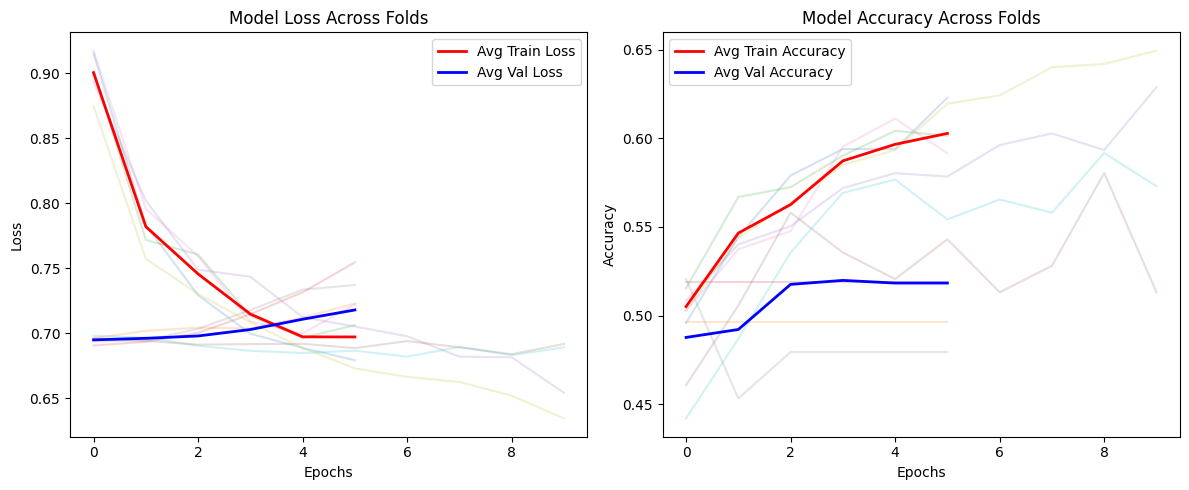

In [13]:
# Print average results
print("\n==== Cross-Validation Results ====")
print(f"Average Training Accuracy: {np.mean(fold_train_accs):.4f} ± {np.std(fold_train_accs):.4f}")
print(f"Average Validation Accuracy: {np.mean(fold_val_accs):.4f} ± {np.std(fold_val_accs):.4f}")
print(f"Average Training Loss: {np.mean(fold_train_losses):.4f} ± {np.std(fold_train_losses):.4f}")
print(f"Average Validation Loss: {np.mean(fold_val_losses):.4f} ± {np.std(fold_val_losses):.4f}")

# Plot average learning curves
plt.figure(figsize=(12, 5))


if histories:
    # Plot average loss
    plt.subplot(1, 2, 1)
    for i, history in enumerate(histories):
        plt.plot(history.history['loss'], alpha=0.2)
        plt.plot(history.history['val_loss'], alpha=0.2)

    min_epochs = min(len(history.history['loss']) for history in histories)
    avg_train_loss = np.mean([history.history['loss'][:min_epochs] for history in histories], axis=0)
    avg_val_loss = np.mean([history.history['val_loss'][:min_epochs] for history in histories], axis=0)
    plt.plot(avg_train_loss, 'r-', linewidth=2, label='Avg Train Loss')
    plt.plot(avg_val_loss, 'b-', linewidth=2, label='Avg Val Loss')
    plt.title('Model Loss Across Folds')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    # Plot average accuracy
    plt.subplot(1, 2, 2)
    for i, history in enumerate(histories):
        plt.plot(history.history['accuracy'], alpha=0.2)
        plt.plot(history.history['val_accuracy'], alpha=0.2)

    min_epochs_acc = min(len(history.history['accuracy']) for history in histories)
    avg_train_acc = np.mean([history.history['accuracy'][:min_epochs_acc] for history in histories], axis=0)
    avg_val_acc = np.mean([history.history['val_accuracy'][:min_epochs_acc] for history in histories], axis=0)
    plt.plot(avg_train_acc, 'r-', linewidth=2, label='Avg Train Accuracy')
    plt.plot(avg_val_acc, 'b-', linewidth=2, label='Avg Val Accuracy')
    plt.title('Model Accuracy Across Folds')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("No training history available. Skipping learning curves plot.")

In [14]:
# Merge the training and validation sets
X_final = np.concatenate([X_train, X_val], axis=0)
y_final = np.concatenate([y_train, y_val], axis=0)

# Create and train the final model
final_model = create_lstm_model(timesteps, n_features)
callbacks_final = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

#Save final model
final_model.save('models/prediction_monthly.keras')

history_final = final_model.fit(
    X_final,
    y_final,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=callbacks_final,
    verbose=1
)

# Evaluate the model on the test set and make predictions
test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=1)
y_test_pred = (final_model.predict(X_test) > 0.5).astype(int).flatten()

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.4796 - loss: 0.9228 - val_accuracy: 0.5000 - val_loss: 0.6917
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.5000 - loss: 0.8322 - val_accuracy: 0.4403 - val_loss: 0.6954
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5889 - loss: 0.7085 - val_accuracy: 0.5000 - val_loss: 0.6912
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5265 - loss: 0.7524 - val_accuracy: 0.5672 - val_loss: 0.6880
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5698 - loss: 0.7035 - val_accuracy: 0.5597 - val_loss: 0.6874
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5643 - loss: 0.7124 - val_accuracy: 0.5299 - val_loss: 0.6860
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5963 - loss: 0.6922 - val_accuracy: 0.5896 - val_loss: 0.6858
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5878 - loss: 0.7051 - val_accuracy: 0.5672 - v